In [16]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
!tar -xzf /content/facades.tar.gz

--2020-11-30 08:46:05--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  3.41MB/s    in 18s     

2020-11-30 08:46:23 (1.59 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]



In [15]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2handbags.tar.gz
!tar -xzf /content/edges2handbags.tar.gz

--2020-11-29 20:41:53--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2handbags.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8556411008 (8.0G) [application/x-gzip]
Saving to: ‘edges2handbags.tar.gz’

edges2handbags.tar. 100%[===================>]   7.97G  4.33MB/s    in 55m 6s  

2020-11-29 21:36:59 (2.47 MB/s) - ‘edges2handbags.tar.gz’ saved [8556411008/8556411008]



In [2]:
!pip install wandb

     |████████████████████████████████| 1.8MB 13.2MB/s 
     |████████████████████████████████| 133kB 59.8MB/s 
     |████████████████████████████████| 102kB 15.3MB/s 
     |████████████████████████████████| 163kB 57.3MB/s 
     |████████████████████████████████| 102kB 13.8MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=8830dcfc9cbd6a5e23012d4596a32099480c8f78c7d216578274ea14b204aab0
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.4-cp36-none-any.whl size=74841 sha256=5a8d3f557c906b9e6ba7a03356b38707dbd5d50513588e70a1a2f97a441eff55
  Stored in directory: /root/.cache/pip/wheels/9e/11/04/5160b8815b0cc7cf574bdc6d053e510169ec264c8791b4ec3a
  Created wheel for pathtools: filename=pathtools-0.1.2-cp36-none-any.whl size=8785 sha256=dc923fda81e6e30d1e337a8c685b03a8ce6f95230f

In [3]:
!ls /content/facades/train | wc -l

ls: cannot access '/content/facades/train': No such file or directory
0


In [17]:
!wandb login ee9416edde558c322450d0ec80266d2c0db81f45

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [20]:
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import os
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
import random
from tqdm.notebook import tqdm

from PIL import Image
import numpy as np

class ImgDataset(Dataset):
    
    def __init__(self, root, folder, transform=None):
        super(ImgDataset).__init__()
        self.root = os.path.join(root, folder)
        self.files = os.listdir(self.root)
        
        
    def __getitem__(self, idx):
        filepath = os.path.join(self.root, self.files[idx])
        img = Image.open(filepath)
        img = transforms.ToTensor()(img)
        width = img.shape[2]
        x, y = img[:, :, width // 2 :], img[:, :, : width // 2] # for facades
        #x, y =  img[:, :, : width // 2], img[:, :, width // 2 :] # for handbags
        return x, y


    def __len__(self):
        return len(self.files)


def make_loader(root, modes=['train', 'val', 'test'], bs=512):
    loaders = []
    for mode, batch_size in zip(modes, [bs, 2, 2]):
	      dataset = ImgDataset(root, mode)
	      loaders.append(DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=1, pin_memory=True))
    return loaders

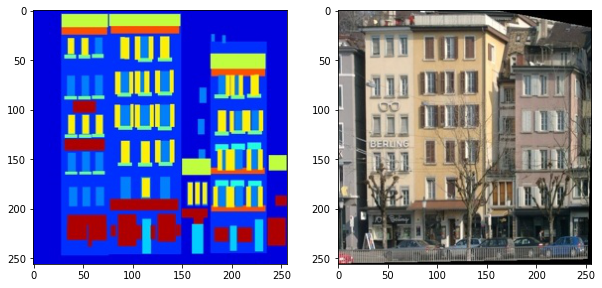

In [21]:
import matplotlib.pyplot as plt
def my_imshow(inp, tar):
    """Imshow for Tensor."""
    inp = transforms.ToPILImage()(inp)
    tar = transforms.ToPILImage()(tar)    
    
    f, axarr = plt.subplots(1, 2) 
    f.set_figheight(5)
    f.set_figwidth(10)
    
    axarr[0].imshow(inp)
    axarr[1].imshow(tar)
root = '/content/facades'
#root = '/content/edges2handbags'
dataset = ImgDataset(root, 'train')
for x, y in dataset:
  break

my_imshow(x, y)

In [22]:
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, checkpoint, patience=7, verbose=False, delta=0, min_loss=np.inf):
        """
        :param
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None if min_loss == np.inf else  -min_loss
        self.early_stop = False
        self.val_loss_min = min_loss
        self.delta = delta
        self.checkpoint = checkpoint

    def __call__(self, val_loss, model, optimizer, scheduler):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, scheduler)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, scheduler)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, scheduler):
        """
        Saves model when validation loss decrease.
        """
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': val_loss
            }, self.checkpoint)

        self.val_loss_min = val_loss



def seed_torch(seed=1):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    n_gpu = torch.cuda.device_count()
    if n_gpu > 0:
        torch.cuda.manual_seed_all(seed)

In [23]:
config = {
    #'up' : [(512, 512), (1024, 1024), (1536, 1024), (1536, 1024), (1536, 1024), (1280, 512), (640, 256), (320, 128)],
    'up' : [(512, 512), (1024, 512), (1024, 512), (1024, 512),  (1024, 512), (768, 512), (640, 256), (320, 128)],
    'down' : [(512, 512), (512, 512), (512, 512), (512, 512), (256, 512), (128, 256), (64, 128), (3, 64)],
    'dropout_p': [0.5, 0.5, 0.5, 0, 0, 0, 0, 0],
    'n_layers': 8,
    'epochs': 25,
    'device': torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
}

In [24]:
print(config['up'][::-1])

[(320, 128), (640, 256), (768, 512), (1024, 512), (1024, 512), (1024, 512), (1024, 512), (512, 512)]


In [53]:
class ConvBlock(nn.Module):

  def __init__(self, in_channels, out_channels, is_top=False):
      super(ConvBlock, self).__init__()
      self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
      self.batch_norm = nn.BatchNorm2d(out_channels) if not is_top else nn.Identity()
      self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)


  def forward(self, x):
      in_shape = x.shape
      x = self.batch_norm(self.conv(x))
      x = self.leaky_relu(x)
      return x


class ConvTBlock(nn.Module):

  def __init__(self, in_channels, out_channels, dropout_p=0):
      super(ConvTBlock, self).__init__()
      self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
      self.batch_norm = nn.BatchNorm2d(out_channels)
      self.relu = nn.ReLU(inplace=True)
      self.dropout_p = dropout_p

  def forward(self, x):
      in_shape = x.shape
      x = self.batch_norm(self.conv(x))
      x = F.dropout(x, p=self.dropout_p)
      x = self.relu(x)
      return x


class UNetLayer(nn.Module):

    def __init__(self, config, subnet, i):

        super(UNetLayer, self).__init__()
        is_bottom = i == 0
        self.is_top = i == config['n_layers'] - 1

        down = ConvBlock(*config['down'][i], self.is_top)
        up = ConvTBlock(*config['up'][i], config['dropout_p'][i])

        if is_bottom:
            self.net = nn.Sequential(down, up)
        else:
            self.net = nn.Sequential(down, subnet, up)

    def forward(self, x):
        if self.is_top:
            return self.net(x)
        else:
            return torch.cat([x, self.net(x)], 1)


class UNet(nn.Module):

  def __init__(self, config):
      super(UNet, self).__init__()
      net = UNetLayer(config, None, 0)
      for i in range(1, config['n_layers']):
          net = UNetLayer(config, net, i)
      self.net = nn.Sequential(
          net,
          nn.Conv2d(config['up'][-1][-1], 3, kernel_size=1),
          nn.Tanh()
      )

  def forward(self, x):
      return self.net(x)
      

In [47]:
conv = ConvBlock(32, 128, False)
conv_t = ConvTBlock(128, 32, 0.5)

img = torch.rand((1, 32, 64, 64))

print(conv(img).shape)
print(conv_t(conv(img)).shape)

layer0 = UNetLayer(config, None, 0)
layer1 = UNetLayer(config, layer0, 1)

img = torch.rand((1, 512, 64, 64))
print(layer1(img).shape)

conv: torch.Size([1, 32, 64, 64])	->	torch.Size([1, 128, 32, 32])
torch.Size([1, 128, 32, 32])
conv: torch.Size([1, 32, 64, 64])	->	torch.Size([1, 128, 32, 32])
conv t: torch.Size([1, 128, 32, 32])	->	torch.Size([1, 32, 64, 64])
torch.Size([1, 32, 64, 64])
conv: torch.Size([1, 512, 64, 64])	->	torch.Size([1, 512, 32, 32])
conv: torch.Size([1, 512, 32, 32])	->	torch.Size([1, 512, 16, 16])
conv t: torch.Size([1, 512, 16, 16])	->	torch.Size([1, 512, 32, 32])
conv t: torch.Size([1, 1024, 32, 32])	->	torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 64, 64])


In [48]:
model = UNet(config)

In [49]:
print(model)

UNet(
  (net): Sequential(
    (0): UNetLayer(
      (net): Sequential(
        (0): ConvBlock(
          (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (batch_norm): Identity()
          (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
        )
        (1): UNetLayer(
          (net): Sequential(
            (0): ConvBlock(
              (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
              (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
            )
            (1): UNetLayer(
              (net): Sequential(
                (0): ConvBlock(
                  (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
                  (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (leaky_relu): LeakyReLU(n

In [50]:
train_loader, val_loader = make_loader(root, modes=['train', 'val'], bs=32)
for x, y in train_loader:
    model(x)
    break

conv: torch.Size([32, 3, 256, 256])	->	torch.Size([32, 64, 128, 128])
conv: torch.Size([32, 64, 128, 128])	->	torch.Size([32, 128, 64, 64])
conv: torch.Size([32, 128, 64, 64])	->	torch.Size([32, 256, 32, 32])
conv: torch.Size([32, 256, 32, 32])	->	torch.Size([32, 512, 16, 16])
conv: torch.Size([32, 512, 16, 16])	->	torch.Size([32, 512, 8, 8])
conv: torch.Size([32, 512, 8, 8])	->	torch.Size([32, 512, 4, 4])
conv: torch.Size([32, 512, 4, 4])	->	torch.Size([32, 512, 2, 2])
conv: torch.Size([32, 512, 2, 2])	->	torch.Size([32, 512, 1, 1])
conv t: torch.Size([32, 512, 1, 1])	->	torch.Size([32, 512, 2, 2])
conv t: torch.Size([32, 1024, 2, 2])	->	torch.Size([32, 512, 4, 4])
conv t: torch.Size([32, 1024, 4, 4])	->	torch.Size([32, 512, 8, 8])
conv t: torch.Size([32, 1024, 8, 8])	->	torch.Size([32, 512, 16, 16])
conv t: torch.Size([32, 1024, 16, 16])	->	torch.Size([32, 512, 32, 32])
conv t: torch.Size([32, 768, 32, 32])	->	torch.Size([32, 512, 64, 64])
conv t: torch.Size([32, 640, 64, 64])	->	tor

In [51]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [52]:
count_parameters(model)

66869443

In [10]:
def train(config, model, optimizer, scheduler, early_stopping,
          train_loader, valid_loader=None):
    device = config['device']
    epochs = config['epochs']
    clip = 15
    criterion = torch.nn.L1Loss()
    for epoch in range(epochs):
        train_epoch(train_loader, model, optimizer, scheduler, device, criterion)
        val_epoch(val_loader, model, optimizer, scheduler, early_stopping, device, criterion, epoch)
        torch.save({
            'model_state_dict': model.state_dict(),
            }, 'latest_checkpoint.pt')

        if early_stopping.early_stop:
            print("Early stopping")
            break

def train_epoch(train_loader, model, optimizer, scheduler, device, criterion, grad_acum=1):
    model.train()
    tr_loss = 0
    tr_steps = 0
    for batch in tqdm(train_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device, non_blocking=True)
        pred = model(x)
        loss = criterion(pred, y)
        tr_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        tr_steps += 1
        wandb.log({'loss/train' : tr_loss / tr_steps})
        if (tr_steps % grad_acum) == 0:
            optimizer.step()
            optimizer.zero_grad()
                

@torch.no_grad()         
def val_epoch(val_loader, model, optimizer, scheduler, early_stopping, device, criterion, epoch):
    val_loss = 0
    val_steps = 0
    for batch in tqdm(val_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device, non_blocking=True)
        pred = model(x)
        loss = criterion(pred, y)
        val_loss += loss.item()
        val_steps += 1
    b_sz = pred.shape[0]
    wandb.log({'loss/val' : val_loss / val_steps,
               "Generated": [wandb.Image(transforms.ToPILImage()(pred[i].cpu().detach()), caption=f'epoch: {epoch}') for i in range(b_sz)],
               "Input": [wandb.Image(transforms.ToPILImage()(x[i].cpu().detach()), caption=f'epoch: {epoch}') for i in range(b_sz)],
               "Ground Truth": [wandb.Image(transforms.ToPILImage()(y[i].cpu().detach()), caption=f'epoch: {epoch}') for i in range(b_sz)],
               })
    early_stopping(val_loss, model, optimizer, scheduler)
    scheduler.step(val_loss)
    return val_loss / val_steps

In [18]:
SEED=1992
seed_torch(SEED)
wandb.init(project='dl hw3', name='handbags', config=config)
model = UNet(config).to(config['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.75)
early_stopping = EarlyStopping(checkpoint='./checkpoint', patience=5, verbose=True)
train_loader, val_loader = make_loader(root, modes=['train', 'val'], bs=32)

In [ ]:
train(config, model, optimizer, scheduler, early_stopping, train_loader, val_loader)


Validation loss decreased (inf --> 10.506167).  Saving model ...



Validation loss decreased (10.506167 --> 10.290731).  Saving model ...
